Boston housing price regression dataset used in this example is taken from the StatLib library which is maintained at Carnegie Mellon University.

Samples contain 13 attributes of houses at different locations around the Boston suburbs in the late 1970s. Targets are the median values of the houses at a location in $K.

The purpose of this notebook is to predict the median values of houses with K-fold, Keras and the dataset described below.

Variables in order (Source: http://lib.stat.cmu.edu/datasets/boston):


| Variables | Description                                                           |
|-----------|-----------------------------------------------------------------------|
| CRIM      | per capita crime rate by town                                         |
| ZN        | proportion of residential land zoned for lots over 25,000 sq.ft.      |
| INDUS     | proportion of non-retail business acres per town                      |
| CHAS      | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX       | nitric oxides concentration (parts per 10 million)                    |
| RM        | average number of rooms per dwelling                                  |
| AGE       | proportion of owner-occupied units built prior to 1940                |
| DIS       | weighted distances to five Boston employment centres                  |
| RAD       | index of accessibility to radial highways                             |
| TAX       | full-value property-tax rate per \$10,000                             |
| PTRATIO   | pupil-teacher ratio by town                                           |
| B         | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town        |
| LSTAT     | % lower status of the population                                      |
| MEDV      | Median value of owner-occupied homes in \$1000's                      |


In [1]:
import matplotlib.pyplot as plt  # plotting
import numpy as np  # linear algebra
import pandas as pd  # data structures
import seaborn as sns  # statistical data visualization
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import boston_housing

Loading housing dataset

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

**Data evaluation**

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_data.ndim

2

In [6]:
train_data.dtype

dtype('float64')

In [7]:
data_labels = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
]
df = pd.DataFrame(train_data, columns=data_labels)
df["MEDV"] = train_targets
df.describe().round(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0
mean,3.7,11.5,11.1,0.1,0.6,6.3,69.0,3.7,9.4,405.9,18.5,354.8,12.7,22.4
std,9.2,23.8,6.8,0.2,0.1,0.7,27.9,2.0,8.7,166.4,2.2,94.1,7.3,9.2
min,0.0,0.0,0.5,0.0,0.4,3.6,2.9,1.1,1.0,188.0,12.6,0.3,1.7,5.0
25%,0.1,0.0,5.1,0.0,0.5,5.9,45.5,2.1,4.0,279.0,17.2,374.7,6.9,16.7
50%,0.3,0.0,9.7,0.0,0.5,6.2,78.5,3.1,5.0,330.0,19.1,391.2,11.4,20.8
75%,3.7,12.5,18.1,0.0,0.6,6.6,94.1,5.1,24.0,666.0,20.2,396.2,17.1,24.8
max,89.0,100.0,27.7,1.0,0.9,8.7,100.0,10.7,24.0,711.0,22.0,396.9,38.0,50.0


House prices range is $5K-50K

How variables are affecting the price of the houses

<Figure size 720x720 with 0 Axes>

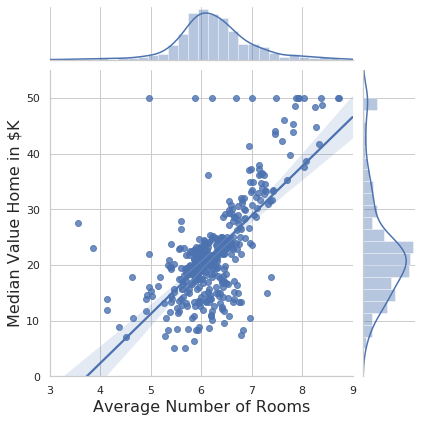

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
sns.jointplot(data=df, x="RM", y="MEDV", kind="reg", xlim=(3, 9), ylim=(0, 55))
plt.ylabel("Median Value Home in $K", fontsize=16)
plt.xlabel("Average Number of Rooms", fontsize=16)
plt.show()

<Figure size 720x720 with 0 Axes>

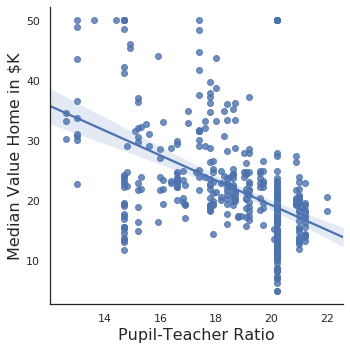

In [9]:
sns.set(style="white")
plt.figure(figsize=(10, 10))
sns.lmplot(data=df, x="PTRATIO", y="MEDV")
plt.ylabel("Median Value Home in $K", fontsize=16)
plt.xlabel("Pupil-Teacher Ratio", fontsize=16)
plt.show()

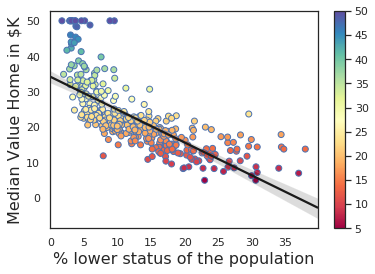

In [10]:
points = plt.scatter(
    df["LSTAT"], df["MEDV"], c=df["MEDV"], cmap="Spectral", edgecolors="b"
)  # set style options

plt.colorbar(points)  # add a color bar
sns.regplot(data=df, x="LSTAT", y="MEDV", scatter=False, color=".1")
plt.ylabel("Median Value Home in $K", fontsize=16)
plt.xlabel("% lower status of the population", fontsize=16)
plt.show()

**Data preparation**

Data is normalized to have zero mean and unit variance before training the model. Note that the same tranformation used for normalizing train data is employed later with test data

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [12]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

**K-fold cross-validation**

K-fold cross-validation approach is employed because the housing dataset size is very small and the validation set would be only 101 samples

Data is splitted in K=4 partitions

In [13]:
from sklearn.model_selection import KFold

K = 4
kf = KFold(n_splits=K)

K identical models are trained using K-1 partitions and they are evaluated using the remaining partition

In [14]:
num_epochs = 400
all_mae_h = []

for j, (train_index, val_index) in enumerate(kf.split(train_data)):
    partial_train_data, val_data = train_data[train_index], train_data[val_index]
    partial_train_targets, val_targets = train_targets[train_index], train_targets[val_index]
    model = build_model()
    result = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
    )

    mae_h = result.history["val_mae"]
    all_mae_h.append(mae_h)
    print(f"Fold {j + 1} finished")

Fold 1 finished
Fold 2 finished
Fold 3 finished
Fold 4 finished


Validation score is the average of the K validation scores

In [15]:
avg_mae_h = [np.mean([x[i] for x in all_mae_h]) for i in range(num_epochs)]

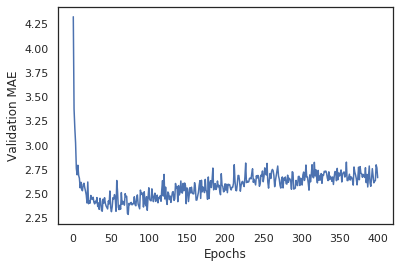

In [16]:
plt.plot(range(1, len(avg_mae_h) + 1), avg_mae_h)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Applying exponential moving average on validation score to obtain a smoother curve and watch the plot better

In [17]:
df_avg_mae_h = pd.DataFrame(avg_mae_h)

smoothed_avg_mae_h = df_avg_mae_h.ewm(alpha=0.1).mean()

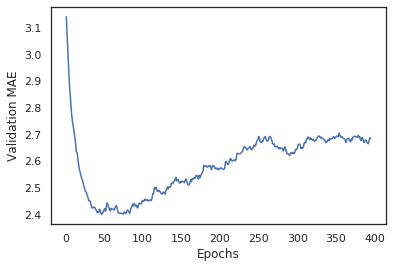

In [18]:
plt.plot(range(1, len(smoothed_avg_mae_h.iloc[5:, 0]) + 1), smoothed_avg_mae_h.iloc[5:, 0])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

The best validation mae value is around 75 epochs

Training final model

In [19]:
final_model = build_model()
final_model.fit(train_data, train_targets, epochs=75, batch_size=16, verbose=0)
test_mse, test_mae = final_model.evaluate(test_data, test_targets)
test_mae

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

2.896791

Final mean absolute error for the median values of houses predicitons is around $2.89K